In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd /gdrive/MyDrive/Colab Notebooks/LfI

/gdrive/MyDrive/Colab Notebooks/LfI


In [3]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.applications.resnet50 import preprocess_input
import random
import matplotlib.pyplot as plt

In [4]:
# Load the .npz file containing test data
npzfile = np.load('Data.npz')

# Extract the test images from the .npz file
X_test = npzfile['images']

# Extract the corresponding test masks from the .npz file
Y_test = npzfile['masks']

# DeepLabV3+

In [5]:
# Load the pre-trained segmentation model from the specified .h5 file
res = load_model('./model/Res_cross_full_model.h5')

In [25]:
# Preprocess the test images before feeding them into the model
X_testDeep = preprocess_input(X_test)

# Make predictions on the test set using the loaded model
Y_predDeep = res.predict(X_testDeep)

# Threshold the predictions to obtain binary masks (convert probabilities to 0 or 1)
threshold = 0.5
Y_pred_binary = (Y_predDeep > threshold).astype(np.uint8)

# Define evaluation metrics for segmentation performance
precision = Precision()  # Precision metric
recall = Recall()  # Recall metric
iou_metric = MeanIoU(num_classes=2)  # Intersection over Union (IoU) for binary segmentation

# Update the metrics' state using the true masks and predicted binary masks
precision.update_state(Y_test, Y_pred_binary)
recall.update_state(Y_test, Y_pred_binary)
iou_metric.update_state(Y_test, Y_pred_binary)

# Compute evaluation results
accuracy = np.mean(Y_test == Y_pred_binary)  # Pixel-wise accuracy calculation
precision_result = precision.result().numpy()  # Compute final precision value
recall_result = recall.result().numpy()  # Compute final recall value
iou_result = iou_metric.result().numpy()  # Compute final IoU value

# Print the evaluation results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision_result:.4f}")
print(f"Test Recall: {recall_result:.4f}")
print(f"Test IoU: {iou_result:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 707ms/step
Test Accuracy: 0.9348
Test Precision: 0.9561
Test Recall: 0.9706
Test IoU: 0.7378


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


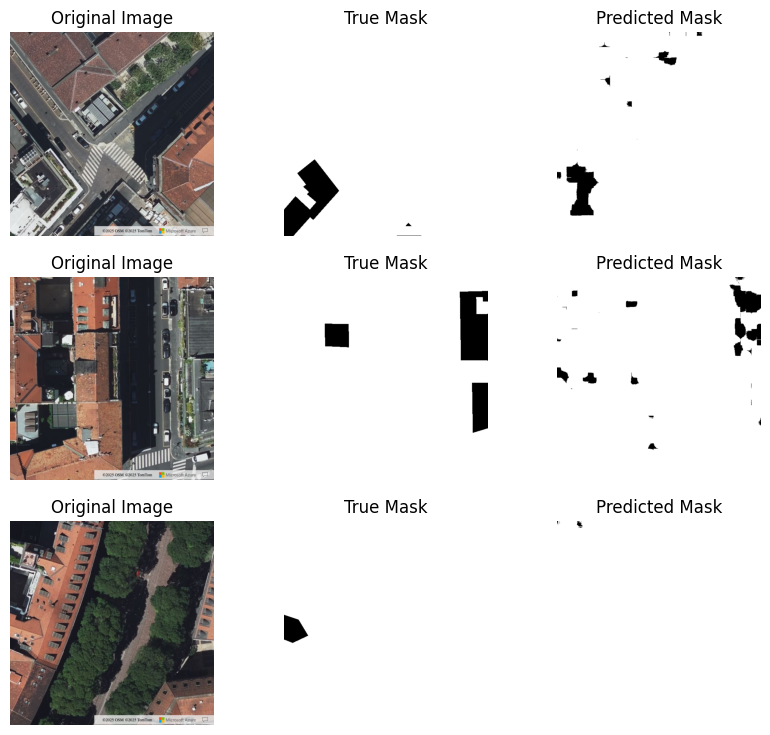

In [36]:
# Function to visualize predictions
def plot_predictions(model, X, Y, num_samples=3):
    # Randomly select 'num_samples' indices from the dataset
    indices = random.sample(range(len(X)), num_samples)

    # Generate predictions for the selected samples
    preds = model.predict(preprocess_input(X[indices]))
    preds = (preds > 0.5).astype(np.uint8)  # Convert probabilities to binary masks

    # Set up the plot
    plt.figure(figsize=(10, num_samples * 3))

    for i, idx in enumerate(indices):
        # Plot the original image (denormalized)
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[idx])
        plt.title('Original Image')
        plt.axis('off')

        # Plot the ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(Y[idx].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Plot the predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    # Show the final plot
    plt.show()

# Display a few prediction examples
plot_predictions(res, X_test, Y_test)

# EfficientNetB7

In [37]:
# Load the saved model from the specified .keras file
eff = load_model('model_effb7_adam_binary_focal_loss_3499_20_100.keras')

In [38]:
# Make predictions on the test set using the EfficientNet model
Y_predEff = eff.predict(X_test, batch_size=8)

# Apply a threshold to convert probability outputs into binary masks
threshold = 0.5
Y_pred_binary = (Y_predEff > threshold).astype(np.uint8)  # Convert to 0 or 1

# Define evaluation metrics for segmentation performance
precision = Precision()  # Precision metric
recall = Recall()  # Recall metric
iou_metric = MeanIoU(num_classes=2)  # IoU (Intersection over Union) for binary segmentation

# Update the metric states using the true and predicted masks
precision.update_state(Y_test, Y_pred_binary)
recall.update_state(Y_test, Y_pred_binary)
iou_metric.update_state(Y_test, Y_pred_binary)

# Compute evaluation results
accuracy = np.mean(Y_test == Y_pred_binary)  # Pixel-wise accuracy calculation
precision_result = precision.result().numpy()  # Compute final precision value
recall_result = recall.result().numpy()  # Compute final recall value
iou_result = iou_metric.result().numpy()  # Compute final IoU value

# Print the evaluation results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision_result:.4f}")
print(f"Test Recall: {recall_result:.4f}")
print(f"Test IoU: {iou_result:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 91s 700ms/step
Test Accuracy: 0.9129
Test Precision: 0.9614
Test Recall: 0.9400
Test IoU: 0.6777


[612, 449, 65]
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


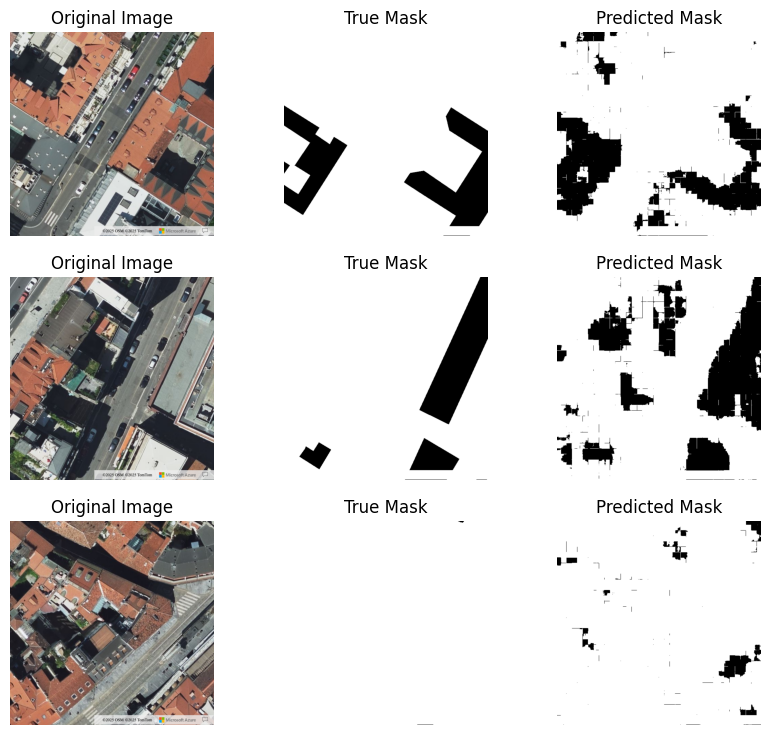

In [39]:
# Visualize predictions
def plot_predictions(model, X, Y, num_samples=3):
    indices = random.sample(range(len(X)), num_samples)
    preds = model.predict(X[indices])
    preds = (preds > 0.5).astype(np.uint8)  # Convert to binary masks

    plt.figure(figsize=(10, num_samples * 3))
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[idx])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(Y[idx].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

# Show sample predictions
plot_predictions(eff, X_test, Y_test)

# Ensemble

In [ ]:
ensemble_preds = (Y_predEff + Y_predRes) / 2  # Media delle predizioni

# Threshold the predictions (convert probabilities to binary masks)
threshold = 0.5
Y_pred_binary = (ensemble_preds > threshold).astype(np.uint8)

# Define metrics
precision = Precision()
recall = Recall()
iou_metric = MeanIoU(num_classes=2)  # Assuming binary segmentation

# Update state for batch evaluation
precision.update_state(Y, Y_pred_binary)
recall.update_state(Y, Y_pred_binary)
iou_metric.update_state(Y[:200], Y_pred_binary[:200])

# Compute results
accuracy = np.mean(Y == Y_pred_binary)  # Pixel-wise accuracy
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
iou_result = iou_metric.result().numpy()

# Print results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision_result:.4f}")
print(f"Test Recall: {recall_result:.4f}")
print(f"Test IoU: {iou_result:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 215ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step
Test Accuracy: 0.9500
Test Precision: 0.9759
Test Recall: 0.9668
Test IoU: 0.8251


[560, 464, 205]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


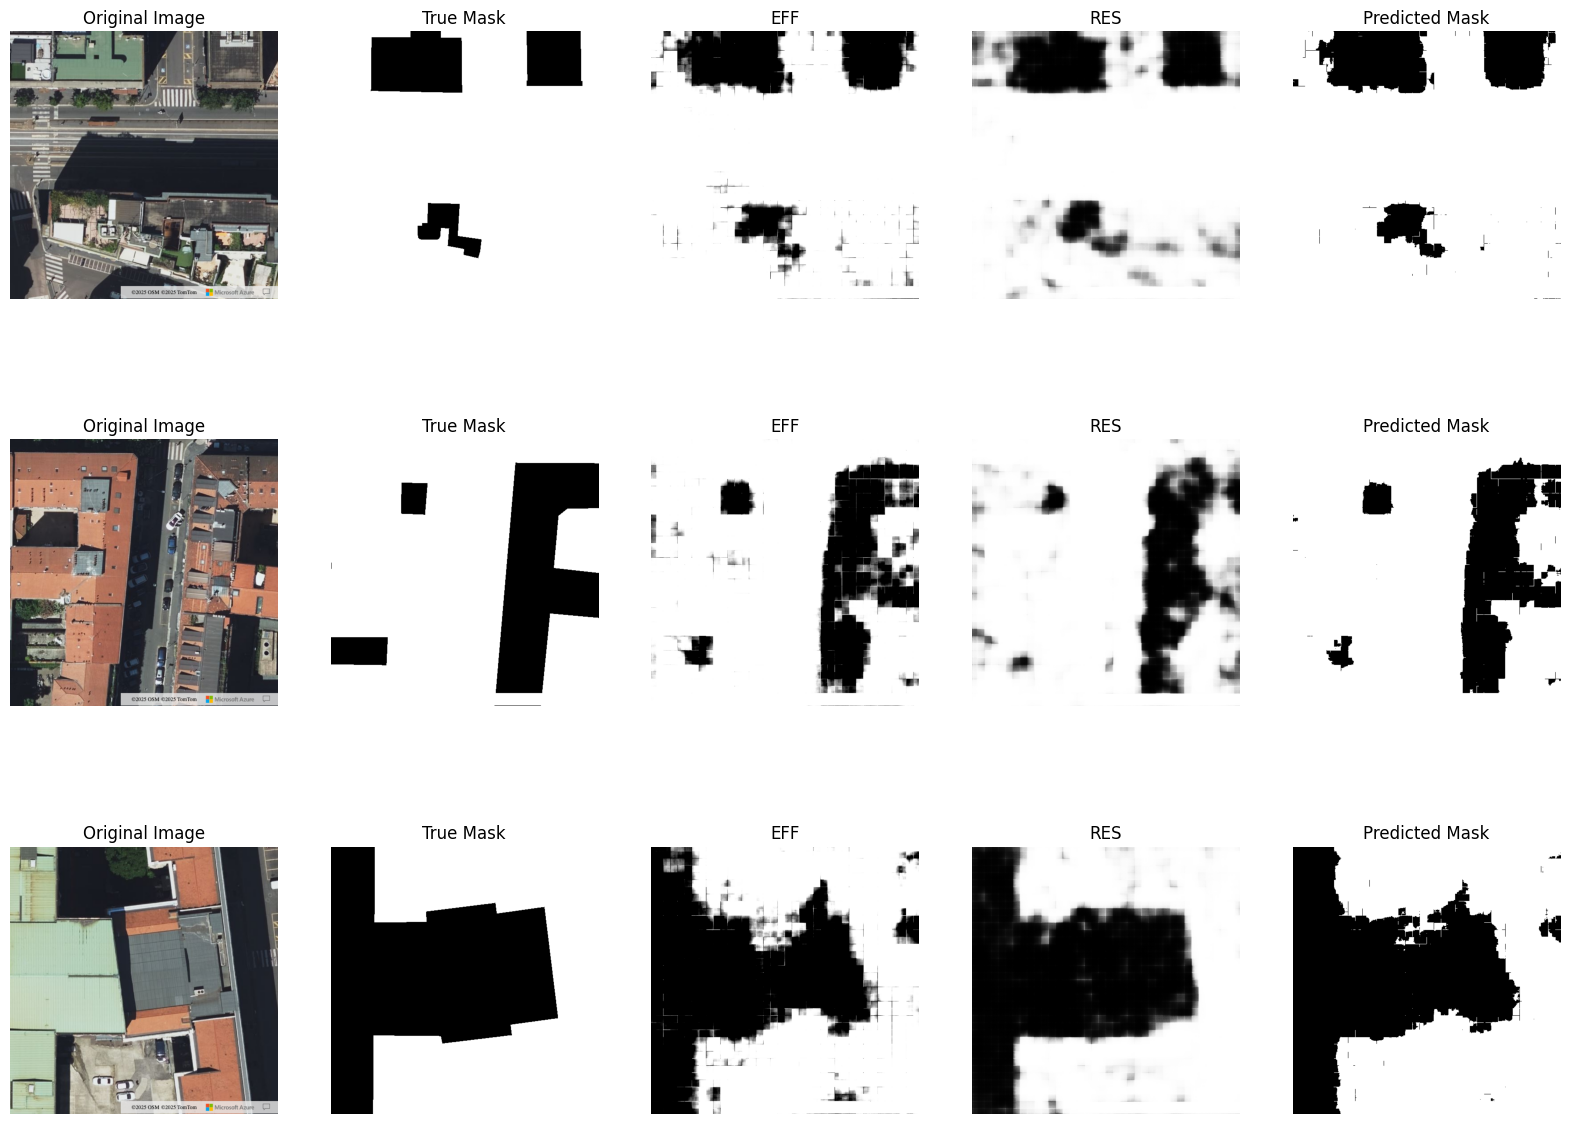

In [ ]:
# Visualize predictions
def plot_predictions(model, X, Y, num_samples=3):
    indices = random.sample(range(len(X)), num_samples)
    print(indices)
    Y_eff_pred = eff.predict(X[indices], batch_size=8)
    X_res = preprocess_input(X[indices])
    Y_res_pred = res.predict(X_res)
    ensemble_preds = (Y_eff_pred + Y_res_pred) / 2  # Media delle predizioni
    preds = (ensemble_preds > 0.5).astype(np.uint8)

    plt.figure(figsize=(20, num_samples * 5))
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 5, i * 5 + 1)
        plt.imshow(X[idx])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 5, i * 5 + 2)
        plt.imshow(Y[idx].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(num_samples, 5, i * 5 + 3)
        plt.imshow(Y_predEff[i].squeeze(), cmap='gray')
        plt.title('# EfficientNetB7')
        plt.axis('off')

        plt.subplot(num_samples, 5, i * 5 + 4)
        plt.imshow(Y_predRes[i].squeeze(), cmap='gray')
        plt.title('DeepLabV3+')
        plt.axis('off')

        plt.subplot(num_samples, 5, i * 5 + 5)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Ensemble')
        plt.axis('off')
    plt.show()

# Show sample predictions
plot_predictions(eff, X, Y)